In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from scipy.special import exp1,factorial
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib
import os
import glob
import json
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import binom,nbinom
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter

In [19]:
plt.rcParams['font.family']='Arial'

In [20]:
def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,rho,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_prob_seg(n,w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,rho,sigma,s)
    return 1 - ((s*rho*lc*lc*lam)/(s*rho*lc*lc*lam+n))**(mu*rho*lc*lc*lam)

def seg_allele_freq(n,w,rho,sigma,s,mu):
    pr_seg = get_prob_seg(n,w,rho,sigma,s,mu)
    return (mu/s)/pr_seg

def get_het(w,rho,sigma,s,mu):
    lc = get_lc(sigma,s)
    lam = get_lambda_theory(w,rho,sigma,s)
    theta = mu*rho*lc*lc*lam
    gamma = s*rho*lc*lc*lam
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_prob_seg_unif(n,s,mu,N):
    gamma = s*N
    theta = mu*N
    return 1 - (gamma/(gamma+n))**theta

def seg_allele_freq_unif(n,s,mu,N):
    prob_seg = get_prob_seg_unif(n,s,mu,N)
    return (mu/s)/prob_seg

def get_het_unif(s,mu,N):
    gamma = s*N
    theta = mu*N
    return (2*theta/gamma)*(1-((1-theta)/gamma))

def get_EP_sim(ps, zeros):
    return np.sum(ps) / (len(ps) + zeros)

def get_EPsquared_sim(ps, zeros):
    return (np.sum(ps ** 2) / (len(ps) + zeros))

def get_lambda_sim(EP,EPsquared,sigma,s):
    lc = get_lc(sigma,s)
    return EP/(s*rho*lc*lc*(EPsquared-EP**2))

def load_data(file):
    with open(file, "r") as json_file:
        data = json.load(json_file)
    return data

def concatenate_data(files):
    combined_sampled_p = []
    combined_zero_samples = 0
    for f in files:
        data = load_data(f)
        combined_sampled_p.extend(data['sampled_p_flattened'])
        combined_zero_samples += data['zero_samples']
    return np.array(combined_sampled_p), combined_zero_samples

def sample_sfs(ps, zeros, n, max_allele_count=10):
    running_sfs = np.zeros(max_allele_count + 1)
    ps = np.where(ps > 1e-100, ps, 0.0)
    j = np.arange(max_allele_count)
    pmf_matrix = binom.pmf(j[:, np.newaxis], n, ps)
    running_sfs[:-1] = np.sum(pmf_matrix, axis=1)
    running_sfs[-1] = np.sum(binom.sf(max_allele_count - 1, n, ps))
    running_sfs[0] += zeros
    expected_sfs = running_sfs / np.sum(running_sfs)
    return expected_sfs

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

In [21]:
colors = ['darkorange','orchid','steelblue']
colors_n = ['mediumseagreen','deeppink','dodgerblue','blueviolet']

In [22]:
rho = 20
s_list = [0.1, 0.01, 0.001]
sigma = 10

L=1000
mu=1e-09
w_list_sim = w_list = np.logspace(1, 4, 10)[0:7]

sim_data = []
for s in s_list:
    for w in w_list_sim:
        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w}*"
        files = glob.glob(os.path.join(file_path))
        # print(files) 
        
        if len(files) == 10:
            print(s)
            print(w)
            combined_sampled_p, combined_zero_samples = concatenate_data(files)
            EP = get_EP_sim(combined_sampled_p,combined_zero_samples)
            EPsquared = get_EPsquared_sim(combined_sampled_p,combined_zero_samples)
            sim_data.append({'s': s, 'sigma': sigma, 'w': w, 'EP': EP, 'EPsquared': EPsquared})
sim_df = pd.DataFrame(sim_data)

0.1
10.0
0.1
21.544346900318832
0.1
46.41588833612777
0.1
100.0
0.1
215.44346900318823
0.1
464.15888336127773
0.1
1000.0
0.01
10.0
0.01
21.544346900318832
0.01
46.41588833612777
0.01
100.0
0.01
215.44346900318823
0.01
464.15888336127773
0.01
1000.0
0.001
10.0
0.001
21.544346900318832
0.001
46.41588833612777
0.001
100.0
0.001
215.44346900318823
0.001
464.15888336127773
0.001
1000.0


In [23]:
sim_df['lambda_sim'] = get_lambda_sim(sim_df['EP'], sim_df['EPsquared'], sim_df['sigma'], sim_df['s'])                                

In [24]:
w_colorbar = np.linspace(10,265,20)
norm = mcolors.Normalize(vmin=w_colorbar.min(), vmax=w_colorbar.max())
cmap = cm.viridis

In [25]:
w_list = np.logspace(1,4,40)
w_list = w_list[w_list<=200]#[250]
w_list

w_plot = [w_list_sim[2],w_list_sim[3],w_list_sim[4]]

In [26]:
plt.rcParams['axes.labelsize'] = 8    
plt.rcParams['axes.titlesize'] = 9    
plt.rcParams['xtick.labelsize'] = 8   
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 8

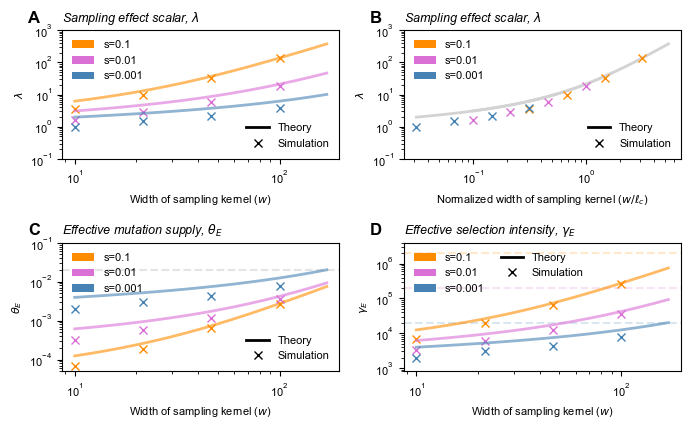

In [10]:
fig = plt.figure(figsize=(7.01,4.4))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.text(-0.1, 1.06, 'A', transform=ax1.transAxes, 
         fontsize=12, fontweight='bold', ha='center')
ax2.text(-0.1, 1.06, 'B', transform=ax2.transAxes, 
         fontsize=12, fontweight='bold', ha='center')
ax3.text(-0.1, 1.06, 'C', transform=ax3.transAxes, 
         fontsize=12, fontweight='bold', ha='center')
ax4.text(-0.1, 1.06, 'D', transform=ax4.transAxes, 
         fontsize=12, fontweight='bold', ha='center')

for i,s in enumerate(s_list):
    lambda_theory = [get_lambda_theory(w,rho,sigma,s) for w in w_list]
    ax1.loglog(w_list,lambda_theory,label=str(s),color=colors[i],alpha=0.6,linewidth=2)
    ax1.loglog(sim_df[sim_df['s']==s]['w'][:-3],sim_df[sim_df['s']==s]['lambda_sim'][:-3],color=colors[i],marker='x',linestyle='None',markersize=6)

ax1.set_ylim(1e-1,1e3)
ax1.set_xlabel(r"Width of sampling kernel ($w$)")
ax1.set_ylabel(r"$\lambda$")
ax1.set_title(r"Sampling effect scalar, $\lambda$",fontstyle='italic',loc='left')

elements = [Patch(facecolor=colors[0],edgecolor='None',label=f's={s_list[0]}'),
            Patch(facecolor=colors[1],edgecolor='None',label=f's={s_list[1]}'),
            Patch(facecolor=colors[2],edgecolor='None',label=f's={s_list[2]}')]
leg1 = ax1.legend(handles=elements,frameon=False,loc='upper left')
ax1.add_artist(leg1)
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=6)]
ax1.legend(handles=elements2,frameon=False,loc='lower right')

ax2.set_ylim(1e-1,1e3)
for s in s_list:
    lambda_theory = [get_lambda_theory(w,rho,sigma,s) for w in w_list]
    lc = get_lc(sigma,s)
    ax2.loglog([w/lc for w in w_list],lambda_theory,color='lightgray',linestyle='-',alpha=1,linewidth=2)

for i,s in enumerate(s_list):
    # lambda_theory = [get_lambda_theory(w,rho,sigma,s) for w in w_list]
    lc = get_lc(sigma,s)
    ax2.loglog(sim_df[sim_df['s']==s]['w'][:-3]/lc,sim_df[sim_df['s']==s]['lambda_sim'][:-3],color=colors[i],marker='x',linestyle='None',markersize=6)

ax2.set_xlabel(r"Normalized width of sampling kernel ($w/\ell_c$)")
ax2.set_ylabel(r"$\lambda$")
ax2.set_title(r"Sampling effect scalar, $\lambda$",fontstyle='italic',loc='left')

leg1 = ax2.legend(handles=elements,frameon=False,loc='upper left')
ax2.add_artist(leg1)
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=6)]
ax2.legend(handles=elements2,frameon=False,loc='lower right')

N = L*L*rho
ax3.axhline(mu*N,color='lightgray',linestyle='--',alpha=0.6)

for i,s in enumerate(s_list):
    lc = get_lc(sigma,s)
    theta_theory = [get_lambda_theory(w,rho,sigma,s)*mu*rho*lc*lc for w in w_list]
    ax3.loglog(w_list,theta_theory,label=str(s),color=colors[i],alpha=0.6,linewidth=2)
    ax3.loglog(sim_df[sim_df['s']==s]['w'][:-3],sim_df[sim_df['s']==s]['lambda_sim'][:-3]*mu*rho*lc*lc,color=colors[i],marker='x',linestyle='None',markersize=6)

leg1 = ax3.legend(handles=elements,frameon=False,loc='upper left')
ax3.add_artist(leg1)
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=6)]
ax3.legend(handles=elements2,frameon=False,loc='lower right')
ax3.set_ylim(5e-5,1e-1)

ax3.set_xlabel(r"Width of sampling kernel ($w$)")
ax3.set_ylabel(r"$\theta_E$")
ax3.set_title(r"Effective mutation supply, $\theta_E$",fontstyle='italic',loc='left')

for i,s in enumerate(s_list):
    ax4.axhline(s*N,color=colors[i],alpha=0.2,linestyle='--')

for i,s in enumerate(s_list):
    lc = get_lc(sigma,s)
    gamma_theory = [get_lambda_theory(w,rho,sigma,s)*s*rho*lc*lc for w in w_list]
    ax4.loglog(w_list,gamma_theory,label=str(s),color=colors[i],alpha=0.6,linewidth=2)
    ax4.loglog(sim_df[sim_df['s']==s]['w'][:-3],sim_df[sim_df['s']==s]['lambda_sim'][:-3]*s*rho*lc*lc,color=colors[i],marker='x',linestyle='None',markersize=6)

leg1 = ax4.legend(handles=elements,frameon=False,loc='upper left')
ax4.add_artist(leg1)
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=6)]
ax4.legend(handles=elements2,frameon=False,loc='upper center')
ax4.set_ylim(8e2,4e6)

ax4.set_xlabel(r"Width of sampling kernel ($w$)")
ax4.set_ylabel(r"$\gamma_E$")
ax4.set_title(r"Effective selection intensity, $\gamma_E$",fontstyle='italic',loc='left')

plt.tight_layout()
plt.savefig('results_effectiveparams_PNASformat.pdf')
plt.show()

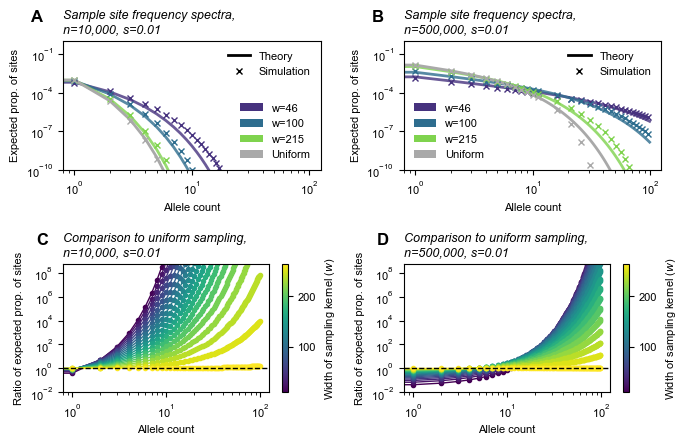

In [11]:
fig = plt.figure(figsize=(7.01, 4.6))
gs = fig.add_gridspec(2, 2, height_ratios=[1,1])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])

elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=5)]

ax3.text(-0.1, 1.15, 'A', transform=ax3.transAxes, 
      fontsize=12, fontweight='bold', ha='center')
ax4.text(-0.1, 1.15, 'B', transform=ax4.transAxes, 
         fontsize=12, fontweight='bold', ha='center')
ax5.text(-0.1, 1.15, 'C', transform=ax5.transAxes, 
         fontsize=12, fontweight='bold', ha='center')
ax6.text(-0.1, 1.15, 'D', transform=ax6.transAxes, 
         fontsize=12, fontweight='bold', ha='center')


ax3.set_title("Sample site frequency spectra,\nn=10,000, s=0.01",fontstyle='italic',loc='left',fontsize=9)

max_x=100
s=0.01
n=10000
L = 1000
w_plot = [w_list_sim[2],w_list_sim[3],w_list_sim[4]]

for i,w in enumerate(w_plot):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)]
    ax3.loglog(np.arange(0, max_x), nb_dist, label=f'w={round(w,1)}', marker=None, linestyle='-',
                                      linewidth=2, alpha=0.8, color=cmap(norm(w)))
N = rho*L*L
nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
ax3.loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='darkgray',linewidth=2,linestyle='-')

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[0]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)
ax3.loglog(np.arange(0, max_x), sfs[0:max_x], marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[0])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[1]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)
ax3.loglog(np.arange(0, max_x), sfs[0:max_x], marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[1])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[2]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)
ax3.loglog(np.arange(0, max_x), sfs[0:max_x], marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[2])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_uniform*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)
ax3.loglog(np.arange(0, max_x), sfs[0:max_x], marker='x',
                                      linestyle='',
                                      markersize=5, color='darkgray')


ax3.set_ylim(1e-10, 1e0)
ax3.set_xlabel('Allele count')
ax3.set_ylabel('Expected prop. of sites')

ax4.set_title("Sample site frequency spectra,\nn=500,000, s=0.01",fontstyle='italic',loc='left')
n=500000
for i,w in enumerate(w_plot):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)]
    ax4.loglog(np.arange(0, max_x), nb_dist, label=f'w={round(w,1)}', marker=None, linestyle='-',
                                      linewidth=2, alpha=0.8, color=cmap(norm(w)))
nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
ax4.loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='darkgray',linewidth=2,linestyle='-')

x_values = np.arange(0, max_x)
file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[0]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
# combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
thin_factor = 5
x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
ax4.loglog(x_values_thinned, sfs_thinned, marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[0])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[1]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
# combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
ax4.loglog(x_values_thinned, sfs_thinned, marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[1])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[2]}*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
# combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
ax4.loglog(x_values_thinned, sfs_thinned, marker='x',
                                      linestyle='',
                                      markersize=5, color=cmap(norm(w_plot[2])))

file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_uniform*"
files = glob.glob(os.path.join(file_path))
combined_sampled_p, combined_zero_samples = concatenate_data(files)
# combined_sampled_p
sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
ax4.loglog(x_values_thinned, sfs_thinned, marker='x',
                                      linestyle='',
                                      markersize=5, color='darkgray')

ax4.set_ylim(1e-10, 1e0)
ax4.set_xlabel('Allele count')
ax4.set_ylabel('Expected prop. of sites')

elements = [Patch(facecolor=cmap(norm(w_plot[0])),edgecolor='None',label=f'w={round(w_plot[0])}'),
            Patch(facecolor=cmap(norm(w_plot[1])),edgecolor='None',label=f'w={round(w_plot[1])}'),
            Patch(facecolor=cmap(norm(w_plot[2])),edgecolor='None',label=f'w={round(w_plot[2])}'),
            Patch(facecolor='darkgray',edgecolor='None',label='Uniform')]
leg1 = ax3.legend(handles=elements,frameon=False,loc='lower right')
ax3.add_artist(leg1)
ax3.legend(handles=elements2,frameon=False,loc='upper right')

leg1 = ax4.legend(handles=elements,frameon=False,loc='lower left')
ax4.add_artist(leg1)
ax4.legend(handles=elements2,frameon=False,loc='upper right')

# w = w_colorbar[-1]
n = 10000
sfs_unif = np.array([get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)])
# sfs_wbroad = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)])
# ax5.plot(np.arange(0, max_x),sfs_w100/sfs_w100)


for w in w_colorbar:
    sfs_temp = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)])
    color = cmap(norm(w))
    ax5.loglog(np.arange(0, max_x),sfs_temp/sfs_unif,marker='o',markersize=3,color=color,linewidth=1)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax5)
cbar.set_label(r'Width of sampling kernel ($w$)')

ax5.set_xlabel('Allele count')
ax5.set_ylabel('Ratio of expected prop. of sites')
ax5.set_title("Comparison to uniform sampling,\nn=10,000, s=0.01",fontstyle='italic',loc='left')
ax5.set_ylim(1e-2,5.6e8)
ax5.axhline(1.0,color='black',linewidth=1,linestyle='dashed')

n = 500000
sfs_unif = np.array([get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)])
# sfs_wbroad = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)])
# ax5.plot(np.arange(0, max_x),sfs_w100/sfs_w100)

for w in w_colorbar:
    sfs_temp = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)])
    color = cmap(norm(w))
    ax6.loglog(np.arange(0, max_x),sfs_temp/sfs_unif,marker='o',markersize=3,color=color,linewidth=1)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax6)
cbar.set_label(r'Width of sampling kernel ($w$)')

ax6.set_xlabel('Allele count')
ax6.set_ylabel('Ratio of expected prop. of sites')
ax6.set_title("Comparison to uniform sampling,\nn=500,000, s=0.01",fontstyle='italic',loc='left')
ax6.set_ylim(1e-2,5.6e8)
ax6.axhline(1.0,color='black',linewidth=1,linestyle='dashed')

plt.tight_layout()
plt.savefig('results_sfs_PNASformat.pdf')
plt.show()

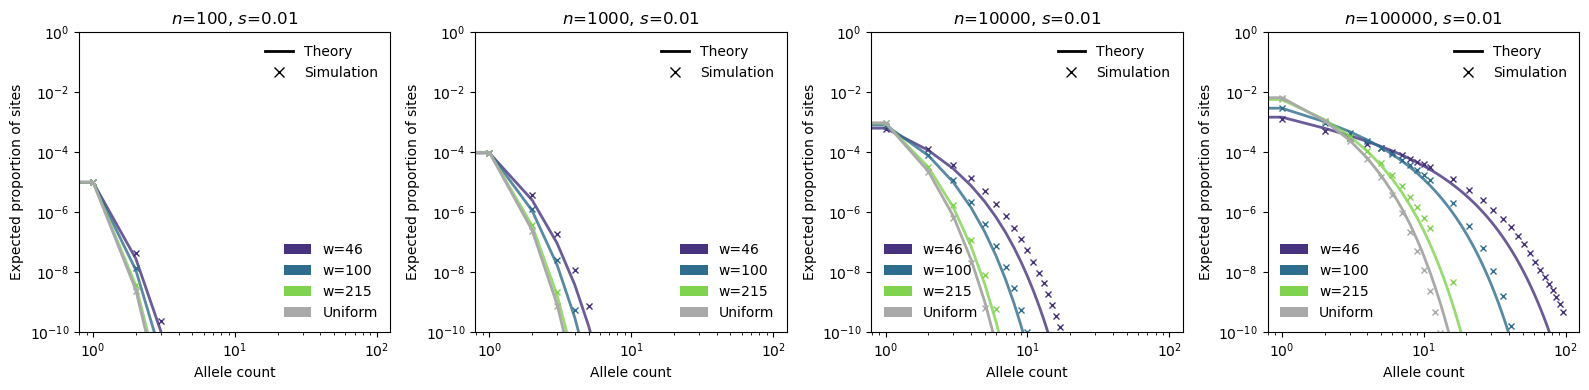

In [15]:
# fig, axs = plt.subplots(1,4,figsize=(7.01,7.01))

# elements = [Patch(facecolor=cmap(norm(w_plot[0])),edgecolor='None',label=f'w={round(w_plot[0])}'),
#             Patch(facecolor=cmap(norm(w_plot[1])),edgecolor='None',label=f'w={round(w_plot[1])}'),
#             Patch(facecolor=cmap(norm(w_plot[2])),edgecolor='None',label=f'w={round(w_plot[2])}'),
#             Patch(facecolor='darkgray',edgecolor='None',label='Uniform')]
# elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
#              Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=7)]

# max_x=100
# x_values = np.arange(0, max_x)
# s=0.01
# L = 1000
# rho = 20
# N = rho*L*L
# n_list = [100,1000,10000,100000]
# w_plot = [w_list_sim[2],w_list_sim[3],w_list_sim[4]]
# thin_factor = 5
# for j,n in enumerate(n_list):
#     for i,w in enumerate(w_plot):
#         nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)]
#         axs[j].loglog(np.arange(0, max_x), nb_dist, label=f'w={round(w,1)}', marker=None, linestyle='-',
#                                           linewidth=2, alpha=0.8, color=cmap(norm(w)))

#         file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w}*"
#         files = glob.glob(os.path.join(file_path))
#         combined_sampled_p, combined_zero_samples = concatenate_data(files)
#         sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
#         if n==100000:
#             x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
#             sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
#             axs[j].loglog(x_values_thinned, sfs_thinned, marker='x',
#                                                   linestyle='',
#                                                   markersize=4, color=cmap(norm(w)))
#         else:
#             axs[j].loglog(np.arange(0, max_x), sfs[0:max_x], marker='x',
#                                         linestyle='',
#                                         markersize=4, color=cmap(norm(w)))
    
#     nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
#     axs[j].loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='darkgray',linewidth=2,linestyle='-')


#     file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_uniform*"
#     files = glob.glob(os.path.join(file_path))
#     combined_sampled_p, combined_zero_samples = concatenate_data(files)
#     sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
#     # x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
#     # sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
#     axs[j].loglog(x_values, sfs, marker='x',
#                                           linestyle='',
#                                           markersize=4, color='darkgray')
    
#     axs[j].set_title(f'$n$={n}, $s$={s}')
#     axs[j].set_ylim(1e-10, 1e0)
#     axs[j].set_xlabel('Allele count')
#     axs[j].set_ylabel('Expected proportion of sites')
#     if j<=1:
#         leg1 = axs[j].legend(handles=elements,frameon=False,loc='lower right')
#     else:
#         leg1 = axs[j].legend(handles=elements,frameon=False,loc='lower left')
#     axs[j].add_artist(leg1)
#     axs[j].legend(handles=elements2,frameon=False,loc='upper right')

# plt.tight_layout()
# plt.savefig('sfs_four_n.pdf')
# plt.show()

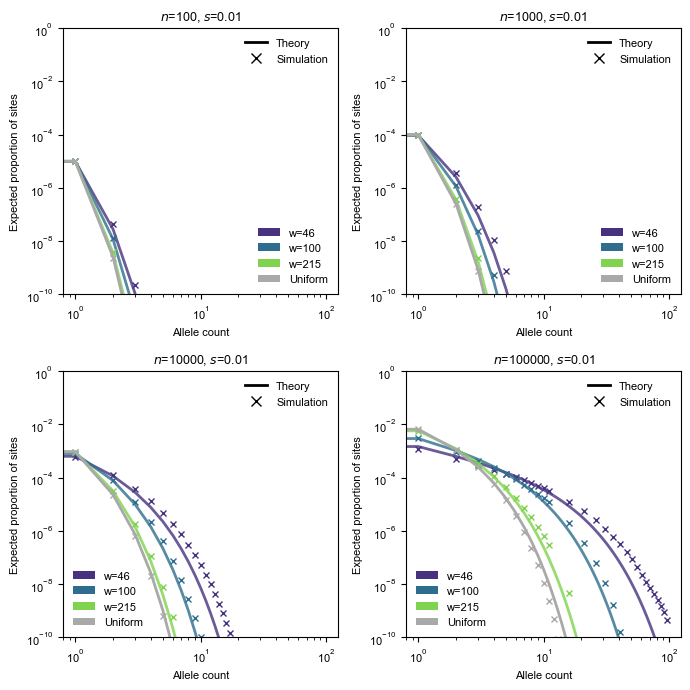

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(7.01, 7.01))  # 2x2 layout

elements = [Patch(facecolor=cmap(norm(w_plot[0])), edgecolor='None', label=f'w={round(w_plot[0])}'),
            Patch(facecolor=cmap(norm(w_plot[1])), edgecolor='None', label=f'w={round(w_plot[1])}'),
            Patch(facecolor=cmap(norm(w_plot[2])), edgecolor='None', label=f'w={round(w_plot[2])}'),
            Patch(facecolor='darkgray', edgecolor='None', label='Uniform')]
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=7)]

max_x = 100
x_values = np.arange(0, max_x)
s = 0.01
L = 1000
rho = 20
N = rho * L * L
n_list = [100, 1000, 10000, 100000]
w_plot = [w_list_sim[2], w_list_sim[3], w_list_sim[4]]
thin_factor = 5

for j, n in enumerate(n_list):
    ax = axs[j // 2, j % 2]  # Map to 2x2 grid
    
    for i, w in enumerate(w_plot):
        nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)]
        ax.loglog(np.arange(0, max_x), nb_dist, label=f'w={round(w, 1)}', linestyle='-', linewidth=2, alpha=0.8, color=cmap(norm(w)))

        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w}*"
        files = glob.glob(os.path.join(file_path))
        combined_sampled_p, combined_zero_samples = concatenate_data(files)
        sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]

        if n == 100000:
            x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
            sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
            ax.loglog(x_values_thinned, sfs_thinned, marker='x', linestyle='', markersize=4, color=cmap(norm(w)))
        else:
            ax.loglog(np.arange(0, max_x), sfs[:max_x], marker='x', linestyle='', markersize=4, color=cmap(norm(w)))
    
    nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
    ax.loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit', color='darkgray', linewidth=2, linestyle='-')

    file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_uniform*"
    files = glob.glob(os.path.join(file_path))
    combined_sampled_p, combined_zero_samples = concatenate_data(files)
    sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
    
    ax.loglog(x_values, sfs, marker='x', linestyle='', markersize=4, color='darkgray')

    ax.set_title(f'$n$={n}, $s$={s}')
    ax.set_ylim(1e-10, 1e0)
    ax.set_xlabel('Allele count')
    ax.set_ylabel('Expected proportion of sites')

    loc = 'lower right' if j <= 1 else 'lower left'
    leg1 = ax.legend(handles=elements, frameon=False, loc=loc)
    ax.add_artist(leg1)
    ax.legend(handles=elements2, frameon=False, loc='upper right')

plt.tight_layout()
plt.savefig('sfs_four_n.pdf')
plt.show()


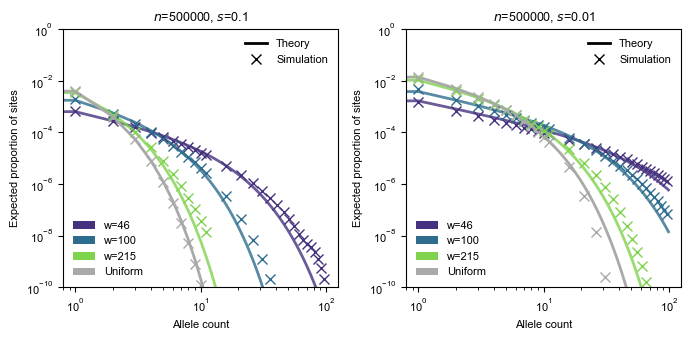

In [30]:
elements2 = [Line2D([0], [0], color='black', label='Theory', linewidth=2),
             Line2D([0], [0], marker='x', color='w', label='Simulation', markeredgecolor='black', markersize=7)]
w_colorbar = np.linspace(10,265,20)
norm = mcolors.Normalize(vmin=w_colorbar.min(), vmax=w_colorbar.max())
cmap = cm.viridis

# ax3.set_title("Sample site frequency spectra, n=10,000, s=0.01",fontstyle='italic',loc='left')

max_x=100
n=500000#10000
L = 1000

rho = 20
s_list = [0.1, 0.01, 0.001]
sigma = 10
mu=1e-09
w_list_sim = np.logspace(1, 4, 10)[0:7]


w_plot = [w_list_sim[2],w_list_sim[3],w_list_sim[4]]
x_values = np.arange(0, max_x)
for n in [500000]:#[10000,500000]:
    fig,axs = plt.subplots(1,2,figsize=(7.01, 3.5))
    if n==500000:
        thin_factor = 5
    else:
        thin_factor = 1
    for j,s in enumerate(s_list[:-1]):
    
        for i,w in enumerate(w_plot):
            nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)]
            axs[j].loglog(np.arange(0, max_x), nb_dist, label=f'w={round(w,1)}', marker=None, linestyle='-',
                                              linewidth=2, alpha=0.8, color=cmap(norm(w)))
        N = rho*L*L
        nb_dist_unif = [get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)]
        axs[j].loglog(np.arange(0, max_x), nb_dist_unif, label='uniform limit',color='darkgray',linewidth=2,linestyle='-')
    
        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[0]}*"
        files = glob.glob(os.path.join(file_path))
        combined_sampled_p, combined_zero_samples = concatenate_data(files)
        sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
        x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
        sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
        axs[j].loglog(x_values_thinned, sfs_thinned, marker='x',
                                              linestyle='',
                                              markersize=7, color=cmap(norm(w_plot[0])))
    
        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[1]}*"
        files = glob.glob(os.path.join(file_path))
        combined_sampled_p, combined_zero_samples = concatenate_data(files)
        combined_sampled_p
        sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
        x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
        sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
        axs[j].loglog(x_values_thinned, sfs_thinned, marker='x',
                                              linestyle='',
                                              markersize=7, color=cmap(norm(w_plot[1])))
            
        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_wrapped_norm_gaussian_w{w_plot[2]}*"
        files = glob.glob(os.path.join(file_path))
        combined_sampled_p, combined_zero_samples = concatenate_data(files)
        combined_sampled_p
        sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
        x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
        sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
        axs[j].loglog(x_values_thinned, sfs_thinned, marker='x',
                                              linestyle='',
                                              markersize=7, color=cmap(norm(w_plot[2])))
    
        file_path = f"../bp_sims/results/20240521/s{s}_mu{mu}_rho{rho}_L{L}_sigma{sigma}_time1000000.0_r0.1_burnin_uniform*"
        files = glob.glob(os.path.join(file_path))
        combined_sampled_p, combined_zero_samples = concatenate_data(files)
        combined_sampled_p
        sfs = sample_sfs(combined_sampled_p, combined_zero_samples, n, max_x)[:100]
        x_values_thinned = np.concatenate((x_values[x_values <= 10], x_values[x_values > 10][::thin_factor]))
        sfs_thinned = np.concatenate((sfs[x_values <= 10], sfs[x_values > 10][::thin_factor]))
        axs[j].loglog(x_values_thinned, sfs_thinned, marker='x',
                                              linestyle='',
                                              markersize=7, color='darkgray')
    
        elements = [Patch(facecolor=cmap(norm(w_plot[0])),edgecolor='None',label=f'w={round(w_plot[0])}'),
                    Patch(facecolor=cmap(norm(w_plot[1])),edgecolor='None',label=f'w={round(w_plot[1])}'),
                    Patch(facecolor=cmap(norm(w_plot[2])),edgecolor='None',label=f'w={round(w_plot[2])}'),
                    Patch(facecolor='darkgray',edgecolor='None',label='Uniform')]
        if j==0 and n==10000:
            leg1 = axs[j].legend(handles=elements,frameon=False,loc='lower right')
        else:
            leg1 = axs[j].legend(handles=elements,frameon=False,loc='lower left')
        axs[j].add_artist(leg1)
        axs[j].legend(handles=elements2,frameon=False,loc='upper right')
    
        axs[j].set_ylim(1e-10, 1e0)
        axs[j].set_xlabel('Allele count')
        axs[j].set_ylabel('Expected proportion of sites')
        axs[j].set_title(rf'$n$={n}, $s$={s}')
    
    plt.tight_layout()
    plt.savefig(f'results_sfs_overs_n{n}.pdf')
    # plt.show()

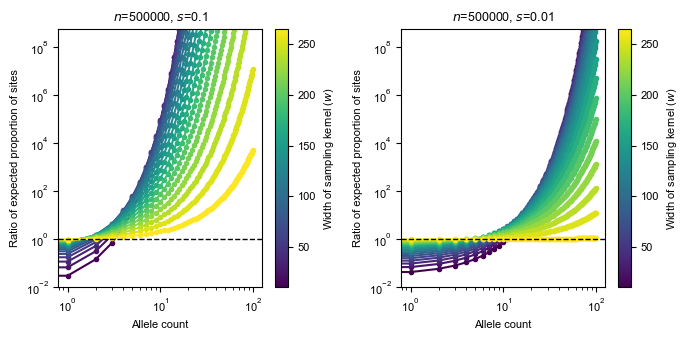

In [17]:
fig,axs = plt.subplots(1,2,figsize=(7.01, 3.5))

# # w = w_colorbar[-1]
# n = 10000
n = 500000
for j,s in enumerate(s_list[:-1]):
    sfs_unif = np.array([get_sfs_theory_unif(y, n, mu, s, N) for y in np.arange(0, max_x)])
    
    for w in w_colorbar:
        sfs_temp = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) for y in np.arange(0, max_x)])
        color = cmap(norm(w))
        axs[j].loglog(np.arange(0, max_x),sfs_temp/sfs_unif,marker='o',markersize=3,color=color)
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axs[j])
    cbar.set_label(r'Width of sampling kernel ($w$)')
    
    axs[j].set_xlabel('Allele count')
    axs[j].set_ylabel('Ratio of expected proportion of sites')
    axs[j].set_title(rf"$n$={n}, $s$={s}")
    axs[j].set_ylim(1e-2,5.6e8)
    axs[j].axhline(1.0,color='black',linewidth=1,linestyle='dashed')

plt.tight_layout()
plt.savefig(f'ratio_sfs_overs_n{n}.pdf')
plt.show()